In [1]:
import torch
from datasets.dataset import DatasetFromFolder
from utils.visualization import visualize_one, visualize_pairs, visualize_triplets
from models.baseline import ConvBlock, UpConvBlock, Baseline
from utils.metrics import psnr
from utils import utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_dataset = DatasetFromFolder("data/div2k/train")

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle=True,
    pin_memory=True,
    batch_size=16,
    num_workers=4)

In [3]:
def pair_to_images(pair):
    return tuple(map(utils.normalized_tensor_to_image, pair))

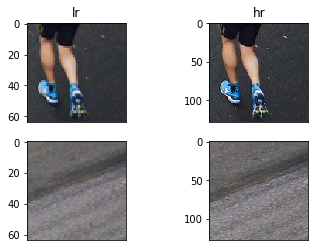

In [4]:
images = list(map(pair_to_images, (train_dataset[i] for i in range(10,12))))
visualize_pairs(*images)

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [6]:
model = Baseline(device, 
          ConvBlock(3, 32, 7),
          ConvBlock(32, 64, 7),
          ConvBlock(64, 128, 7),
          UpConvBlock(128, upscale=2),
          ConvBlock(128, 3)
        )


In [7]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True)

In [8]:
errs, metrics = list(), list()
for epoch in range(2):
    print("Epoch {} started".format(epoch))
    model.train()
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        batch_features = data.float().to(device)
        batch_labels = target.float().to(device)
        
        batch_preds = model.forward(batch_features)

        loss = criterion(batch_preds, batch_labels)
        loss.backward()
        optimizer.step()
        
        if i % 25 == 0:
            err = loss.item()
            errs.append(err)
            
            metric = psnr(err)
            metrics.append(metric)
            print("Batch {} loss {}, ".format(i, err), end="")
            print("PSNR: {}".format(metric))

Epoch 0 started
Batch 0 loss 0.09081423282623291, PSNR: 53.34003401621169


Process Process-2:
Process Process-1:
Process Process-4:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/galecore/anaconda3/envs/superres/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/galecore/anaconda3/envs/superres/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/galecore/anaconda3/envs/superres/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/galecore/anaconda3/envs/superres/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/galecore/anaconda3/envs/superres/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/galecore/anaconda3/envs/superres/lib/python3.6/multiprocessing/process.py", lin

KeyboardInterrupt: 

In [9]:
def upscale_one(path, model=model):
    prediction_batch = utils.to_batch(utils.read_data(path))
    prediction = model.predict(prediction_batch)
    return utils.normalized_tensor_to_image(prediction).squeeze()



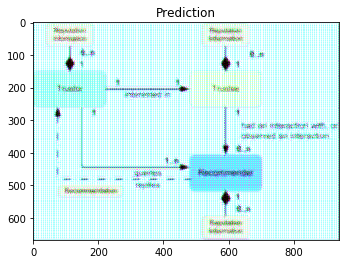

In [10]:
prediction_batch = utils.to_batch(utils.read_data("/home/galecore/Downloads/image_2019-01-21_18-19-05.jpg"))
prediction = model.predict(prediction_batch)

visualize_one("Prediction", utils.normalized_tensor_to_image(prediction).squeeze())

In [11]:
# create (data, target) -> (data, prediction, target)
#map(lambda make_triplet, zip(pairs, predictions))

In [13]:
torch.save(model.state_dict(), "state_dict.wght")